# COSI 107 Report Demonstration

## Author: Michelangelo Zampieri 

This notebook contains the code for the demonstration section in my report for COSI 107 Intro to Computer Security. 

Here I create a small CNN for the MNIST dataset, to then create a adversarial attack to demonstrate the effect of these attacks on machine learning models. 

Import needed libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import foolbox as fb 

Check available device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Download the data and prepare the datasets

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean and std for MNIST
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

This is where the CNN is defined. It has the following layers:
1. Convolutional layer 1
2. ReLU activation
3. Max Pooling layer 
4. Convolutional layer 2
5. ReLU activation
6. Max Pooling layer 
7. Flatten layer 

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # (1, 28, 28) → (32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),             # → (32, 14, 14)
            nn.Conv2d(32, 64, 3, padding=1),# → (64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),             # → (64, 7, 7)
            nn.Flatten(),                   # → (64*7*7,)
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

In [6]:
model = SimpleCNN().to(device)

Define the optimizer and loss function

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train the model 

Training could be made better with more epochs and better hardware but this is more than enough for now. 

In [8]:
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}")


Epoch [1/5], Loss: 128.3458
Epoch [2/5], Loss: 41.8396
Epoch [2/5], Loss: 41.8396
Epoch [3/5], Loss: 28.1946
Epoch [3/5], Loss: 28.1946
Epoch [4/5], Loss: 20.1370
Epoch [4/5], Loss: 20.1370
Epoch [5/5], Loss: 16.1634
Epoch [5/5], Loss: 16.1634


Evaluate the model on test images store the predictions for later

In [9]:
all_labels = []
all_preds = []

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 99.02%


Create a confusion matrix

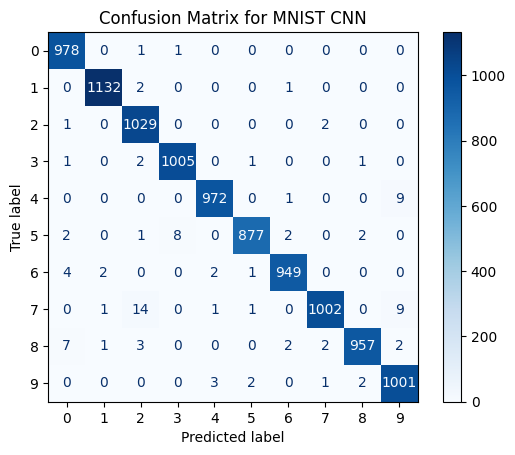

In [10]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for MNIST CNN")
plt.show()

This matrix shows that the model overall is able to guess the classes very well. It seems to make some mistakes with predicting the number `2` instead of the real label `7`. This mistake is resonable as those number are similarly written but this mistake is really small compared to how many are correct. 

Save the model

In [ ]:
os.makedirs('models', exist_ok=True)
torch.save(model.state_dict(), "mnist_cnn.pth")

Functions to predict and plot images

In [ ]:
def predict(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
    return np.array(predictions)

def plot_images(images, labels, predictions=None):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        if predictions is not None:
            title = f"True: {labels[i]}, Pred: {predictions[i]}"
        else:
            title = f"Label: {labels[i]}"
        ax.set_title(title)
        ax.axis('off')
    plt.show()


Get test image labels, make predictions, and plot them. 

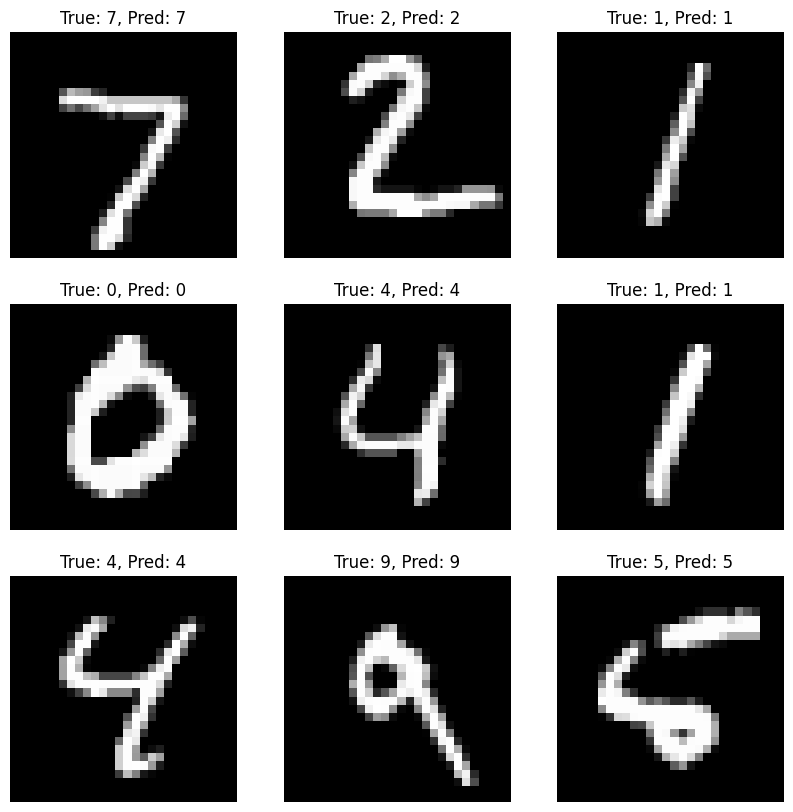

In [ ]:
test_images, test_labels = next(iter(test_loader))
test_images = test_images.numpy()
test_labels = test_labels.numpy()

predictions = predict(model, test_loader)

plot_images(test_images, test_labels, predictions)

As seen here all images seem to be predicted correctly. 